In [1]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

from sklearn.decomposition import NMF
from einops import rearrange
from surfh.Models import wavelength_mrs
from surfh.Simulation import simulation_data
from matplotlib.widgets import Slider


In [3]:
def plot_cube(cube, wavelength_cube):
    
    if cube.shape[0] != 4:
        idx = np.where(np.sum(cube, axis=(1,2)) != 0)[0]
        nzero_slice = slice(idx[0], idx[-1])
        print(nzero_slice)
        cube = cube[nzero_slice, ...]
        wavelength_cube = wavelength_cube[nzero_slice]

    # Initial lambda index
    initial_lambda = 0
    nLambda = cube.shape[0]

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.1, bottom=0.25)  # Adjust the subplot to make space for the slider

    # Display the initial slice
    slice_plot = ax.imshow(cube[initial_lambda, :, :], cmap='viridis')
    ax.set_title(f'Lambda slice: {initial_lambda}')
    ax.plot(7,20,'.')
    ax.plot(37,10,'.')
    ax.plot(14,44,'.')
    ax.plot(40,31,'.')    
    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax)

    # Create the slider axis and slider
    ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Lambda', 0, nLambda - 1, valinit=initial_lambda, valstep=1)

    # Update function to be called when the slider is changed
    def update(val):
        lambda_index = int(slider.val)
        # Update the image data
        new_slice = cube[lambda_index, :, :]
        slice_plot.set_data(new_slice)
        
        # Update the color limits for the current slice
        slice_plot.set_clim(vmin=np.min(new_slice), vmax=np.max(new_slice))

        # Redraw the colorbar with the new limits
        cbar.update_normal(slice_plot)

        # Update the title to show the current lambda slice
        ax.set_title(f'Lambda slice: {wavelength_cube[lambda_index]}')
        
        # Redraw the figure canvas
        fig.canvas.draw_idle()

    # Attach the update function to the slider
    slider.on_changed(update)

    plt.show()

Filename: /home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-shortmediumlong_s3d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     376   ()      
  1  SCI           1 ImageHDU        90   (57, 51, 6315)   float32   
  2  ERR           1 ImageHDU        12   (57, 51, 6315)   float32   
  3  DQ            1 ImageHDU        12   (57, 51, 6315)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (57, 51, 6315)   float32   
  5  WCS-TABLE     1 BinTableHDU     14   1R x 1C   [6315E]   
  6  HDRTAB        1 BinTableHDU    844   24R x 417C   [23A, 5A, 3A, 46A, 7A, 13A, 3A, 7A, 6A, 7A, 13A, 4A, L, D, D, D, D, 4A, 10A, 94A, 14A, 3A, D, 15A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 35A, 21A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 18A, 18A, 5A, D, D, D, D, D, D, D, D, D, 8A, 4A, 11A, D, 2A, D, D, D, D, 6A, D, D, D, 4A, D, D, D, D, D, 3A, 4A, D, D, D, D, D, D, D, D, D, K, 5A, 7A, D, D, D, D, 

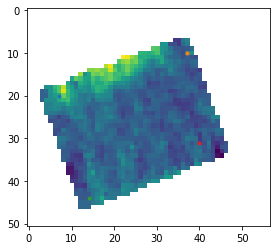

slice(0, 6314, None)


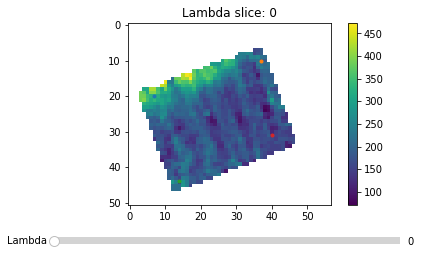

(51, 57)
slice(0, 6314, None)


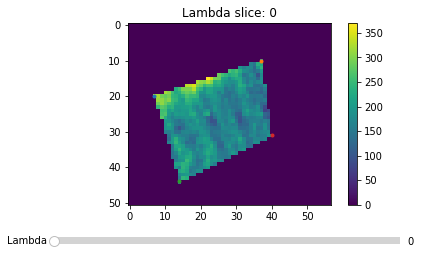

! (6315, 51, 57)
(9786292,)
(13,)


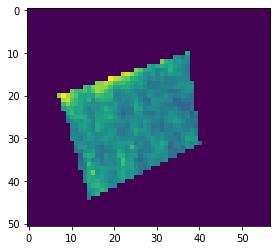

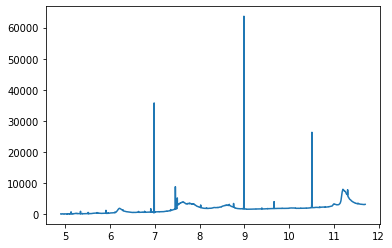

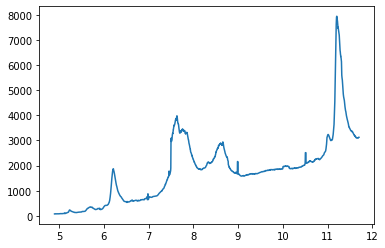

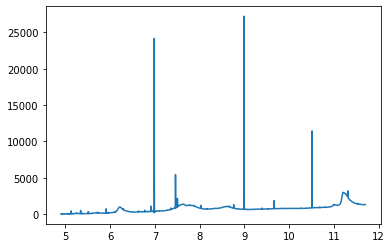

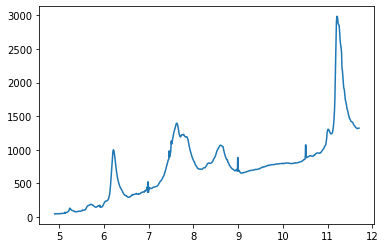

In [4]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-shortmediumlong_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
hdr = hdul[1].header
print(hdul.info())
print(type(hdul[5].data[0]))
print(np.array(hdul[5].data[0])[0,:,0].shape)
wavel = np.array(hdul[5].data[0])[0,:,0]


from skimage.draw import polygon
def mask_polygon(array, coords):
    """
    Retain values within a polygon defined by coordinates and set other values to 0.

    Parameters:
    - array (2D numpy array): The input array
    - coords (list of tuples): List of 4 (x, y) tuples representing the polygon vertices

    Returns:
    - masked_array (2D numpy array): Array with values inside polygon retained, others set to 0
    """
    # Separate x and y coordinates
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    
    # Create a mask for the polygon area
    mask = np.zeros(array.shape[1:], dtype=bool)
    print(mask.shape)
    rr, cc = polygon(y_coords, x_coords, array.shape)
    mask[rr, cc] = True
    
    # Apply the mask to retain values within the polygon, set others to 0
    masked_array = np.where(mask[np.newaxis,...], array, 0)
    
    return masked_array

plt.figure()
plt.imshow(raw_data_cube[100])
plt.plot(7,20,'.')
plt.plot(37,10,'.')
plt.plot(14,44,'.')
plt.plot(40,31,'.')
plt.show()

plot_cube(raw_data_cube, wavel)
coords = [(7,20), (14,44), (40,31), (37,10)]
masked_array = mask_polygon(raw_data_cube, coords)
plot_cube(masked_array, wavel)

print("!",masked_array.shape)
plt.figure()
plt.imshow(masked_array[100])




nan_idx = np.where(np.isnan(data_cube))
print(nan_idx[0].shape)
# replace Nan with 0
data_cube[np.isnan(data_cube)] = 0
fitlered_data_cube = ndimage.median_filter(data_cube.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
fitlered_data = rearrange(fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.plot(wavel, np.mean(data_cube, axis=(1,2)))
plt.figure()
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)))


nan_idx = np.where(np.isnan(masked_array))
print(nan_idx[0].shape)
# replace Nan with 0
masked_array[np.isnan(masked_array)] = 0
masked_array_fitlered_data_cube = ndimage.median_filter(masked_array.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
masked_array_fitlered_data = rearrange(masked_array_fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.plot(wavel, np.mean(masked_array, axis=(1,2)))
plt.figure()
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)))



In [11]:
%matplotlib


plot_cube(raw_data_cube, wavel)
plot_cube(masked_array, wavel)



Using matplotlib backend: TkAgg
slice(0, 6314, None)
slice(0, 6314, None)


/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number 

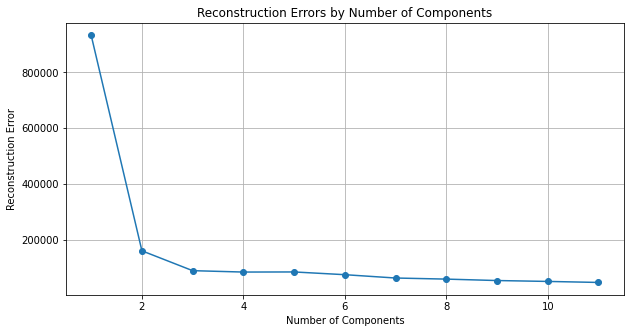

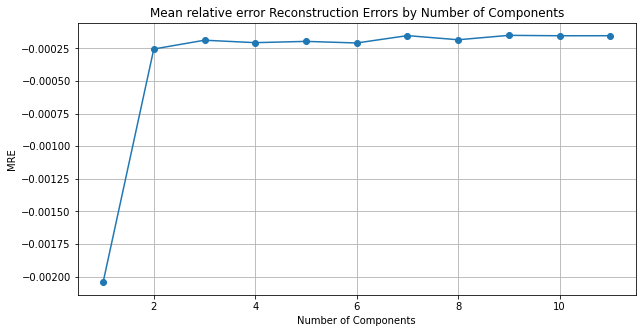

In [4]:
# Range of components to test
component_range = range(1, 12)  # Adjust based on how many tests you want to run

# List to store the reconstruction errors
reconstruction_errors = []
mre_reconstruction_errors = []

# Compute NMF for different numbers of components and calculate the reconstruction errors
for n_components in component_range:
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(masked_array_fitlered_data)  # W is the weight matrix
    H = nmf.components_          # H is the feature matrix (components)
    reconstructed = W @ H        # Reconstruct the original matrix
    error = np.linalg.norm(masked_array_fitlered_data - reconstructed)  # Frobenius norm
    mre_error = np.mean(np.divide((masked_array_fitlered_data-reconstructed), masked_array_fitlered_data, out=np.zeros_like(masked_array_fitlered_data), where=masked_array_fitlered_data!=0))

    reconstruction_errors.append(error)
    mre_reconstruction_errors.append(mre_error)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, mre_reconstruction_errors, marker='o')
plt.title('Mean relative error Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MRE')
plt.grid(True)

/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


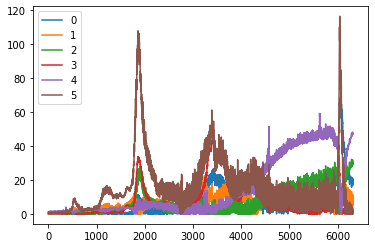

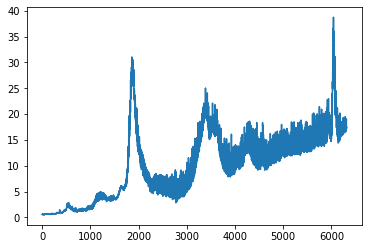

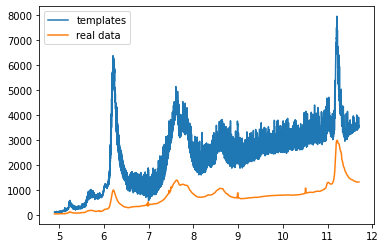

In [5]:
from sklearn.decomposition import NMF

# Initialize NMF with the desired number of components
nmf = NMF(n_components=6, init='random', random_state=0, max_iter=1000)

# Fit NMF model to your data
nmf.fit(masked_array_fitlered_data)

# Extract the components (eigenvectors)
components = nmf.components_

plt.figure()
for i in range(components.shape[0]):
    plt.plot(components[i], label=i)
plt.legend()
 
plt.figure()
plt.plot(np.mean(components, axis=0))


plt.figure()
scale_f = np.max(np.mean(fitlered_data_cube, axis=(1,2)))/np.max(np.mean(components, axis=0))
#scale_f = np.mean(fitlered_data_cube, axis=(1,2))[-1]/np.mean(components, axis=0)[-1]

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.legend()


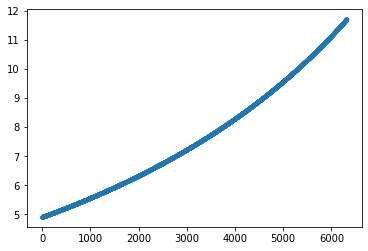

In [19]:
plt.plot(wavel, '.')

[40 44 48 52 56 60 64 68 72 76]
(6, 1578)


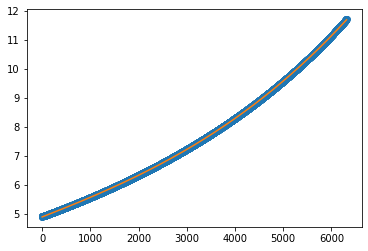

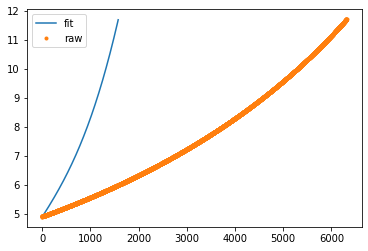

In [6]:
from scipy.optimize import curve_fit

def second_order_function(x, A, B, C):
    return A + B*x**2 + C*x

def third_order_function(x, A, B, C, D):
    return A + D*x**3 + B*x**2 + C*x


def exponential(x, A, B, C):
    return A + B*np.exp(C*x)

def cos_func(x, D, E, A):
    y = A + D*np.cos(E*x)
    return y


xdata = np.arange(len(wavel))
ydata = wavel
parameters, covariance = curve_fit(third_order_function, xdata, ydata)
fit_D = parameters[0]
fit_G = parameters[1]
fit_1 = parameters[2]
fit_2 = parameters[3]


fit_cosine = third_order_function(xdata, fit_D, fit_G, fit_1, fit_2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')


def downsample_interpolation(vector, target_size):
    x_old = np.linspace(0, 1, len(vector))
    x_new = np.linspace(0, 1, target_size)
    return np.interp(x_new, x_old, vector)

#wavel_axis = np.linspace(wavel.min(), wavel.max(), len(wavel)-1)

test = downsample_interpolation(np.arange(len(wavel)), len(wavel)//4)
print((test[10:20].astype(int)))
subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = third_order_function(test.astype(int), fit_D, fit_G, fit_1, fit_2)

wavel_axis = third_order_function(test.astype(int), fit_D, fit_G, fit_1, fit_2)
plt.figure()
plt.plot(wavel_axis, '-', label='fit')
plt.plot(wavel, '.', label='raw')
plt.legend()

subsampled_interpn = np.zeros((components.shape[0], len(test)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = np.interp(wavel_axis, wavel, components[i])


print(subsampled_interpn.shape)

In [14]:

# for i in range(components.shape[0]):
#     subsampled_interpn[i] = downsample_interpolation(components[i], len(wavel_axis))



[20 22 24 26 28 30 32 34 36 38]


In [12]:
def reduce_vector_to_shape(vector, target_shape):
    """
    Reduce a vector by randomly removing elements to reach the specified target shape.\n",
    \n",
    Parameters:\n",
    vector (np.ndarray): The input vector to reduce.\n",
    target_shape (int): The target length of the vector.\n",
    \n",
    Returns:\n",
    np.ndarray: The reduced vector.\n",
    """
    original_shape = vector.shape[0]
 
    first_subsampled_factor = original_shape//target_shape
    tmp_vector = vector[::first_subsampled_factor]
    tmp_shape = tmp_vector.shape[0
                          ]
    # Ensure the target shape is smaller than the original shape\n",
    if target_shape >= original_shape:
        raise ValueError("Target shape must be smaller than the original vector length.")

    # Determine how many elements to remove\n",
    num_elements_to_remove = tmp_shape - target_shape
    # Randomly select indices to remove\n",
    indices_to_remove = np.random.choice(tmp_shape, num_elements_to_remove, replace=False)
    # Remove the selected elements\n",
    reduced_vector = np.delete(tmp_vector, indices_to_remove)
    return reduced_vector

subsampled_components = np.zeros((components.shape[0], len(wavel_axis)))
print(len(wavel_axis))

for i in range(components.shape[0]):
    subsampled_components[i] = reduce_vector_to_shape(components[i], len(wavel_axis))


3157


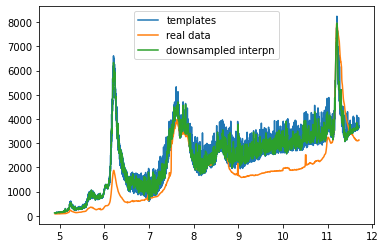

In [7]:
scale_f = np.max(np.mean(fitlered_data_cube, axis=(1,2)))/np.max(np.mean(subsampled_interpn, axis=0))

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(fitlered_data_cube, axis=(1,2)), label='real data')
# plt.plot(wavel_axis, np.mean(subsampled_components, axis=0)*scale_f, label='downsampled')

plt.plot(wavel_axis, np.mean(subsampled_interpn, axis=0)*scale_f, label='downsampled interpn')
# plt.plot(wavel_axis, np.mean(subsampled_fft, axis=0)*scale_fft, label='downsampled fft')

plt.legend()

In [8]:
print(wavel_axis)
print(wavel)

[ 4.88658932  4.88918537  4.89178204 ... 11.66524055 11.67246772
 11.68150909]
[ 4.9        4.9006095  4.901219  ... 11.6967325 11.698607  11.700483 ]


In [7]:
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/nmf_orion_1ABC_2ABC_6_templates_SS4.npy', subsampled_interpn)
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/wavel_axis_orion_1ABC_2ABC_6_templates_SS4.npy', wavel_axis)
